# Logistic Regression with a Neural Network

The purpose of this notebook is to present the implementation of a logistic regression. The dataset is composed of pictures, the goal is to identify pictures of cats.

## 1 - Packages ##

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

## 2 - Overview of the Problem set ##

**Problem Statement**: The dataset ("data.h5") contains:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

In [38]:
def load_dataset():
    train_dataset = h5py.File('./datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('./datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [39]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


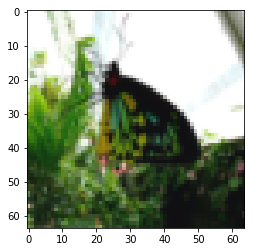

In [40]:
# Example of a picture
index = 16
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + 
       ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + 
       "' picture.")

y = [1], it's a 'cat' picture.


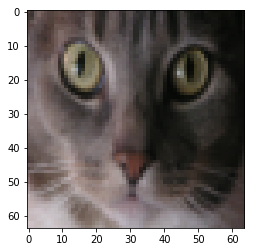

In [41]:
# Example of a picture
index = 60
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + 
       ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + 
       "' picture.")

In [42]:
print(train_set_x_orig.shape)
print(train_set_y.shape)

(209, 64, 64, 3)
(1, 209)


In [43]:
# Display data shape
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


For convenience, we now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

In [44]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize the dataset, meaning that we substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [45]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:518px;height:402px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)


### 4.1 - Helper functions

In [46]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1+ np.exp(-z))
    return s

### 4.2 - Initializing parameters

In [47]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros([dim,1])
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

### 4.3 - Forward and Backward propagation


Forward Propagation:
- Get X
- Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

We are using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [48]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                    # compute activation
    cost = (-1/m) * np.sum( Y*np.log(A) + (1-Y)*np.log(1-A) )       # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m) * np.dot(X,(A-Y).T)
    db = (1/m) * np.sum(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### 4.4 - Optimization

In [49]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
                
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [50]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0,i]<=0.5:
            Y_prediction[0,i]=0.0
        else:
            Y_prediction[0,i]=1.0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

## 5 - Merge all functions into a model ##

WE will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [51]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model.
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [52]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Comment**: Training accuracy is close to 100%. This is a good sanity check: the model is working and has high enough capacity to fit the training data. Test error is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier.

Also, WE see that the model is clearly overfitting the training data.

y = 1
y_pred = 0.0


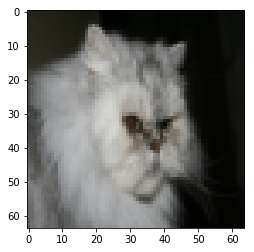

In [68]:
# Example of a picture that was wrongly classified.
index = 10
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print("y = " + str(test_set_y[0,index]))
print("y_pred = "+ str(d['Y_prediction_test'][0,index]))

Let's also plot the cost function and the gradients.

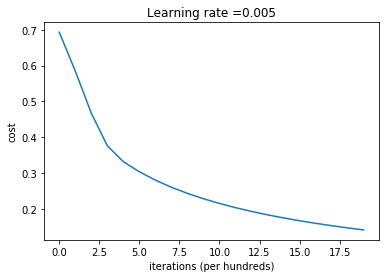

In [69]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
We can see the cost decreasing. It shows that the parameters are being learned. However, we see that we could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. We might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

## 6 - Further analysis ##

#### Choice of learning rate ####

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



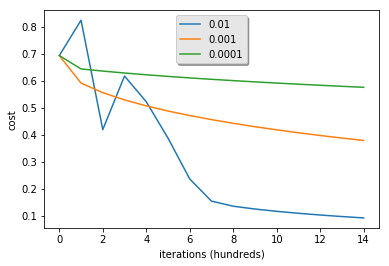

In [70]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. We have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we typically: 
    - Choose the learning rate that better minimizes the cost function.
    - If the model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.) 


## 7 - Test with own image ##


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


y = 1.0, algorithm predicts a "cat" picture.


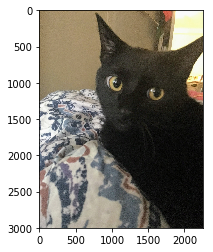

In [72]:
my_image = "Hank_1.jpg"

# We preprocess the image to fit the algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


y = 1.0, algorithm predicts a "cat" picture.


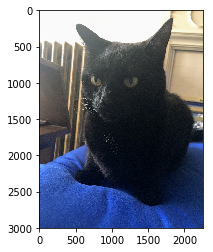

In [73]:
my_image = "Hank_2.jpg"

# We preprocess the image to fit the algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c